In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
product = pd.read_pickle('./datasets/train_labeled_product_series.pkl')
meta = pd.read_pickle('./datasets/train_meta_series.pkl')
dt = pd.merge(left = product, right = meta, left_on = 'date', right_on= 'date')

In [8]:
dt.head().T

,0,1,2,3,4
product_id,89,78,107,124,84
date,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
sessions,636,1006,836,1376,1090
bookings,2,3,5,5,5
product_labels,1,0,0,0,0
consumer_confidence_index,1,1,1,1,1
exchange_rate,0.960528,0.960528,0.960528,0.960528,0.960528
online_visibility,0.995408,0.995408,0.995408,0.995408,0.995408
tv_ad_reach,0,0,0,0,0
weather_index,average,average,average,average,average


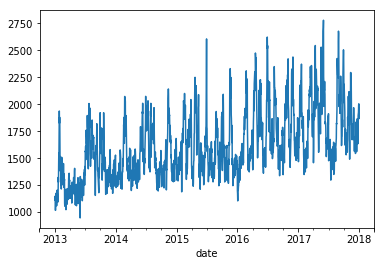

In [9]:
ys = dt.groupby(['date','product_labels'])[['sessions']].mean().unstack()
#y0=ys.iloc[:,0]
ys.iloc[:,0].plot()

In [12]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 30)
SARIMAX: (0, 0, 1) x (0, 1, 0, 30)
SARIMAX: (0, 1, 0) x (0, 1, 1, 30)
SARIMAX: (0, 1, 0) x (1, 0, 0, 30)


In [69]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(
                                        endog = ys.iloc[:1200,0], exog=pd.get_dummies(meta.iloc[:1200,1:]).values,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False
                                        ,enforce_invertibility=False
                                       )

        results = mod.fit()

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 30)12 - AIC:15851.798687919767
ARIMA(0, 0, 0)x(0, 0, 1, 30)12 - AIC:15427.460604818432
ARIMA(0, 0, 0)x(0, 1, 0, 30)12 - AIC:16069.558077486963
ARIMA(0, 0, 0)x(0, 1, 1, 30)12 - AIC:15098.279658614709
ARIMA(0, 0, 0)x(1, 0, 0, 30)12 - AIC:15438.367558971306
ARIMA(0, 0, 0)x(1, 0, 1, 30)12 - AIC:15422.121402817882
ARIMA(0, 0, 0)x(1, 1, 0, 30)12 - AIC:15371.980707865237
ARIMA(0, 0, 0)x(1, 1, 1, 30)12 - AIC:15122.760432621782
ARIMA(0, 0, 1)x(0, 0, 0, 30)12 - AIC:15241.393177499722
ARIMA(0, 0, 1)x(0, 0, 1, 30)12 - AIC:14849.706684754145
ARIMA(0, 0, 1)x(0, 1, 0, 30)12 - AIC:15563.993083815552
ARIMA(0, 0, 1)x(0, 1, 1, 30)12 - AIC:14602.292623037378
ARIMA(0, 0, 1)x(1, 0, 0, 30)12 - AIC:14878.407186960518
ARIMA(0, 0, 1)x(1, 0, 1, 30)12 - AIC:14849.133949651059
ARIMA(0, 0, 1)x(1, 1, 0, 30)12 - AIC:14904.978559990104
ARIMA(0, 0, 1)x(1, 1, 1, 30)12 - AIC:14604.235823506991
ARIMA(0, 1, 0)x(0, 0, 0, 30)12 - AIC:14514.104279826639
ARIMA(0, 1, 0)x(0, 0, 1, 30)12 - AIC:14142.38123

In [15]:
ys.iloc[:,0].shape

(1826,)

In [58]:
pd.get_dummies(meta.iloc[:1200,1:]).values

array([[1.        , 0.96052837, 0.99540838, ..., 1.        , 0.        ,
        0.        ],
       [1.01272878, 0.99432726, 1.00972299, ..., 1.        , 0.        ,
        0.        ],
       [1.01698178, 1.00342224, 0.99761468, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [1.33917109, 1.09591237, 1.86715071, ..., 1.        , 0.        ,
        0.        ],
       [1.3175615 , 1.10524793, 1.78287741, ..., 1.        , 0.        ,
        0.        ],
       [1.32920897, 1.07766801, 1.80176236, ..., 1.        , 0.        ,
        0.        ]])

In [54]:
?sm.tsa.statespace.SARIMAX

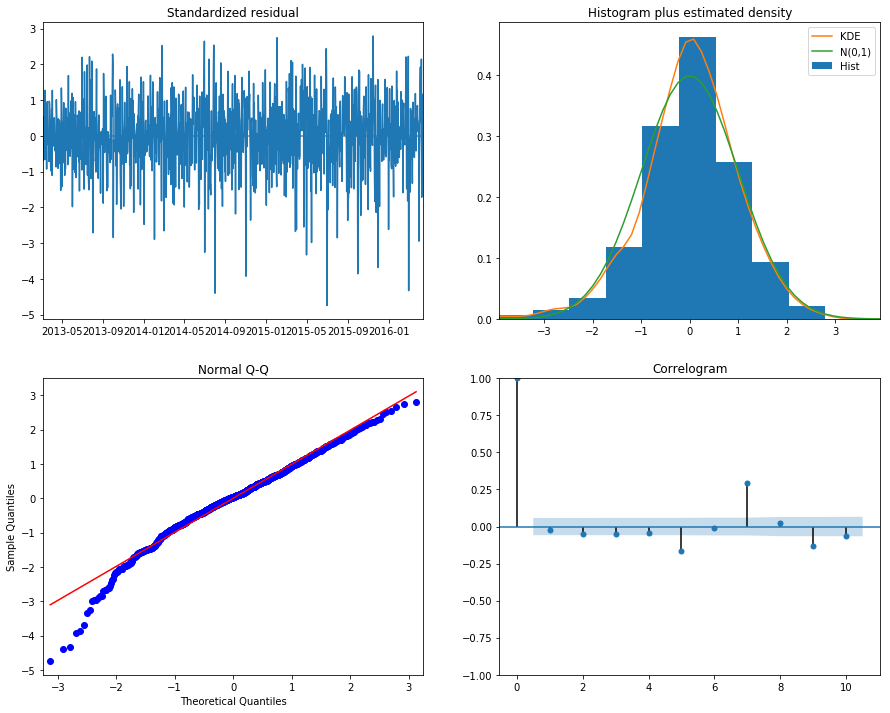

In [59]:
mod = sm.tsa.statespace.SARIMAX(endog = ys.iloc[:1200,0], exog=pd.get_dummies(meta.iloc[:1200,1:]).values,
    order=(1,1,1),
    seasonal_order=(1,1,1,30),
    enforce_stationarity=False
    ,enforce_invertibility=False)
results = mod.fit()
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [68]:
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(1, 1, 1)x(1, 1, 1, 30)12 - AIC:13865.994280867619


In [61]:
pred = results.get_prediction(start=pd.to_datetime('2016-04-16'), dynamic=False, exog=pd.get_dummies(meta.iloc[1201:,1:]).values)
#pred_ci = pred.conf_int()

y_forecasted = pred.predicted_mean

ax = ys.iloc[1201:,0].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()



import math
# Compute the mean square error
mse = math.sqrt(((y_forecasted - ys.iloc[1201:,0]) ** 2).mean())
print('The Mean Root Squared Error of our forecasts is {}'.format(round(mse, 2)))

ValueError: Provided exogenous values are not of the appropriate shape. Required (2, 7), got (805, 7).

In [66]:
#?results.get_forecast(steps=500)
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500, exog=pd.get_dummies(meta.iloc[1201:1701,1:]).values)

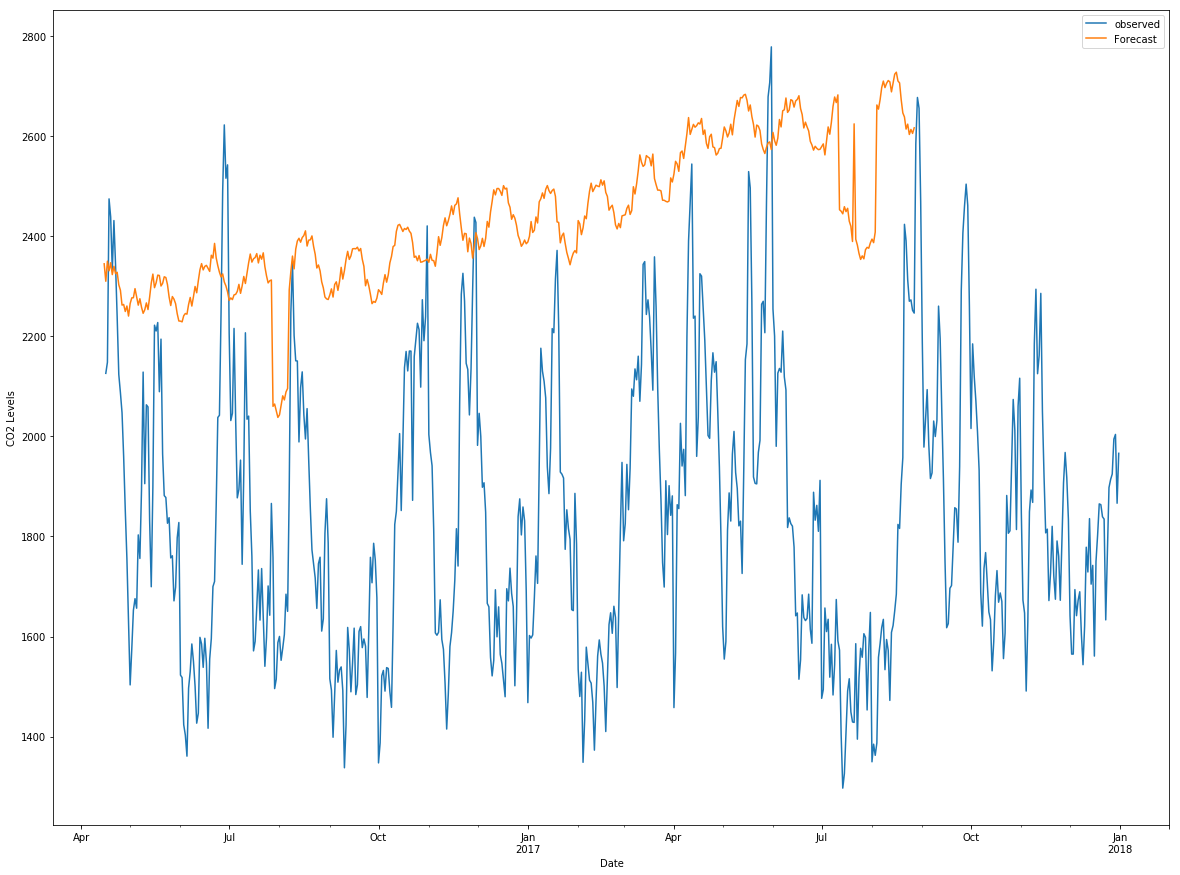

In [67]:
ax = ys.iloc[1201:,0].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()